First, all necessary modules are imported. PyTorch is the primary library, with Sklearn, pandas, and PIL being used for various secondary functions.

In [19]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import ResNet50_Weights, resnet50

The stock photos and AI generated versions are taken from the [[Kaggle Detect AI vs. Human-Generated Images competition](https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images)]. They are stored under the './data/' folder in the project directory.

In [20]:
train_df = pd.read_csv("./data/train.csv", index_col=0)
test_df = pd.read_csv("./data/test.csv")

Then, the train and test sets can be visualized with pandas.

In [21]:
train_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
Index: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...
79945,train_data/9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,train_data/4c6b17fe6dd743428a45773135a10508.jpg,1
79947,train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,train_data/ff960b55f296445abb3c5f304b52e104.jpg,1


In [22]:
test_df.info()
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540 entries, 0 to 5539
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5540 non-null   object
dtypes: object(1)
memory usage: 43.4+ KB


,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg


Using sklearn, the training set is split into a training and validation subset. This is done because labels are not given for the actual test set, so data segmentation must be used to allow for the assessment of data not seen by the model during training. This is done with an 80/20 split to leave enough samples out of the training set for validation. The set is shuffled (with a set random state) and stratified, so that there is an equal number of each label for training and validation.

In [23]:
train_split, val_split = train_test_split(
    train_df, test_size=0.2, shuffle=True, random_state=42, stratify=train_df["label"],
)
train_split.info()
print("\n")
val_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63960 entries, 23023 to 24089
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  63960 non-null  object
 1   label      63960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


<class 'pandas.core.frame.DataFrame'>
Index: 15990 entries, 37734 to 58009
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  15990 non-null  object
 1   label      15990 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 374.8+ KB


The count of each label can be verified.

In [24]:
print(
    f"Label 0 in training set: {train_split[train_split['label'] == 0]['label'].count()}\n"
    f"Label 1 in training set: {train_split[train_split['label'] == 1]['label'].count()}\n"
    f"Label 0 in validation set: {val_split[val_split['label'] == 0]['label'].count()}\n"
    f"Label 1 in validation set: {val_split[val_split['label'] == 1]['label'].count()}",
)

Label 0 in training set: 31980
Label 1 in training set: 31980
Label 0 in validation set: 7995
Label 1 in validation set: 7995


Following the [PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), a custom image dataset class is created to allow the .csv list of training data to be used with PyTorch.

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, category, transform) -> None:
        self.dataframe = dataframe
        self.category = category
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = "./data/" + self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.category in {"train", "val"}:
            label = self.dataframe.iloc[idx, 1]
            return image, label

        if self.category == "test":
            return image

        return None

To allow the CNN to process each image, various transforms must be performed to get them to a consistent and suitable format. First, as the images are of various differing sizes, they are resized to 256x256. This preserves feature information while not taking an exorbitant amount of memory or compute time. Then, the PIL images are transformed to tensors, and lastly, each channel is normalized about a mean and standard deviation.

In [26]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ],
)

Each dataset is created as an instance of **CustomImageDataset**, with the applied transformation.

In [27]:
train_dataset = CustomImageDataset(
    dataframe=train_split,
    category="train",
    transform=transform,
)

val_dataset = CustomImageDataset(
    dataframe=val_split,
    category="val",
    transform=transform,
)

test_dataset = CustomImageDataset(
    dataframe=test_df,
    category="test",
    transform=transform,
)

Then, the DataLoaders are created. A batch size of 128 images is used. The train set is shuffled, while the validation test sets are not. Multiple workers are used to allow for quicker processing, and the *pin_memory* option is used to keep the images cached in GPU memory during training.

In [28]:
batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True,
)

The [ResNet50 model architecture](https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/) was selected to be used for its strong performance in classification tasks. The default weights are loaded, and then the last layer is modified to implement a binary classifier.

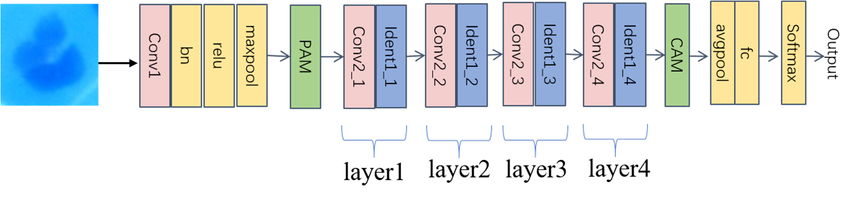

In [29]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)

First, all parameters of the model are frozen. Then, the 4th layer (layer4 above) and the final fully connected output layer (fc above) are unfrozen to allow for training to modify the weights.

In [30]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

To speed up the training, a CUDA enabled GPU is used.

In [31]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
model.to(device)
print(f"Device: {device}")

Device: cuda


Cross-entropy loss is used as the loss function for training, and the Adam optimizer is used for the gradient descent. The Adam algorithm works effectively for training on large scale datasets, which this set meets. A learning rate of 0.001 was used, found through experimentation. Additionally, a learning rate scheduler is used, cutting the learning rate in half after every 3rd epoch. This is intended to prevent overshooting the local minima near the end of training.

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Lastly, the training loop is defined. 15 epochs are used, providing a balance between training time and overall results. At each step, the cumulative loss and correct predictions are tracked on the training and validation sets to later visualize the training run. After each epoch, the updated results are printed and saved to a .txt file.

In [ ]:
epochs = 15
log_file_path = "training_log.txt"
with Path.open(log_file_path, "a") as log:
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_count = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            pred = model(images)
            loss = loss_fn(pred, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(pred.data, 1)
            train_count += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_count
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_correct = 0
        val_count = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                pred = model(images)
                _, predicted = torch.max(pred.data, 1)
                val_count += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_count

        output_string = (
            f"---------------[ Epoch {epoch + 1} ]---------------\n"
            f"Training Accuracy: {train_acc}%\n"
            f"Average Training Loss: {avg_train_loss}\n"
            f"Validation Accuracy: {val_acc}%\n"
        )
        print(output_string)
        log.write(output_string)
        log.flush()

        torch.save(model.state_dict(), "model.pth")

        scheduler.step()

---------------[ Epoch 1 ]---------------
Training Accuracy: 98.21138211382114%
Average Training Loss: 0.04594249412650243
Validation Accuracy: 99.23702313946217%

---------------[ Epoch 2 ]---------------
Training Accuracy: 99.57317073170732%
Average Training Loss: 0.011933937183814124
Validation Accuracy: 99.54346466541588%

---------------[ Epoch 3 ]---------------
Training Accuracy: 99.75766103814884%
Average Training Loss: 0.007374010253039159
Validation Accuracy: 99.47467166979362%

---------------[ Epoch 4 ]---------------
Training Accuracy: 99.9155722326454%
Average Training Loss: 0.002501747967026631
Validation Accuracy: 99.65603502188868%

---------------[ Epoch 5 ]---------------
Training Accuracy: 99.9718574108818%
Average Training Loss: 0.0008700207698514078
Validation Accuracy: 99.61851156973108%

---------------[ Epoch 6 ]---------------
Training Accuracy: 99.92182614133834%
Average Training Loss: 0.0024203518780041124
Validation Accuracy: 99.53095684803002%

-----------

The trained model is loaded from the weights.

In [33]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("model.pth"))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
model.to(device)
print(f"Device: {device}")

Device: cuda


Then, the validation images are passed to the fully trained model to collect the true and predicted labels for each of the 15,990 images.

In [34]:
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred.data, 1)

        true_labels.extend(labels.cpu())
        pred_labels.extend(predicted.cpu())

Sklearn is used to create and plot the confusion matrix, giving more insight into the model's performance on the specific classes.

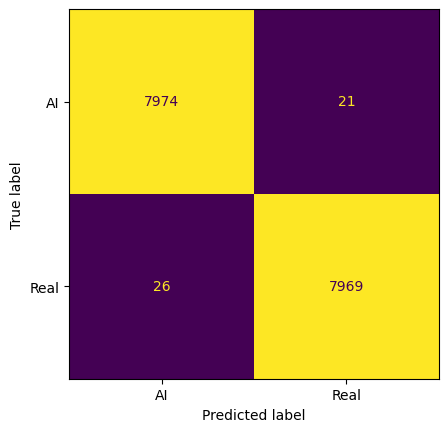

In [35]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=("AI", "Real"))
disp.plot(colorbar=False)

Then, the training_log.txt file is parsed to get the training loss and accuracy, and the validation accuracy.

In [36]:
train_acc_list = []
train_loss_list = []
val_acc_list = []

log_file_path = "training_log.txt"
with Path.open(log_file_path, "r") as log_file:
    for line in log_file:
        if "Training Accuracy:" in line:
            train_acc = float(line.split(": ")[1].strip("%\n"))
            train_acc_list.append(train_acc)
        elif "Average Training Loss:" in line:
            train_loss = float(line.split(": ")[1].strip("\n"))
            train_loss_list.append(train_loss)
        elif "Validation Accuracy:" in line:
            val_acc = float(line.split(": ")[1].strip("%\n"))
            val_acc_list.append(val_acc)

Lastly, all three metrics are plotted.

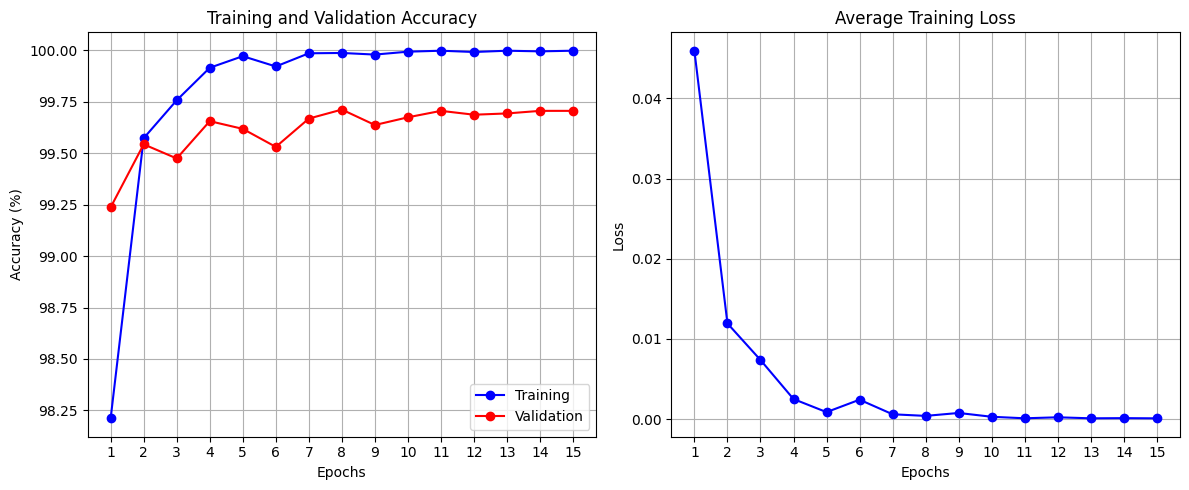

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, "b-o", label="Training")
plt.plot(epochs, val_acc_list, "r-o", label="Validation")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(visible=True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, "b-o")
plt.title("Average Training Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.grid(visible=True)

plt.tight_layout()
plt.show()